[*********************100%%**********************]  1 of 1 completed
Stock data has been saved to stock_data.csv
Outliers:Empty DataFrame
Columns: [Adj Close]
Index: []


            Adj Close
Date                 
2017-01-06  27.433193
2017-01-13  27.696098
2017-01-20  27.919451
2017-01-27  28.373142
2017-02-03  30.032028


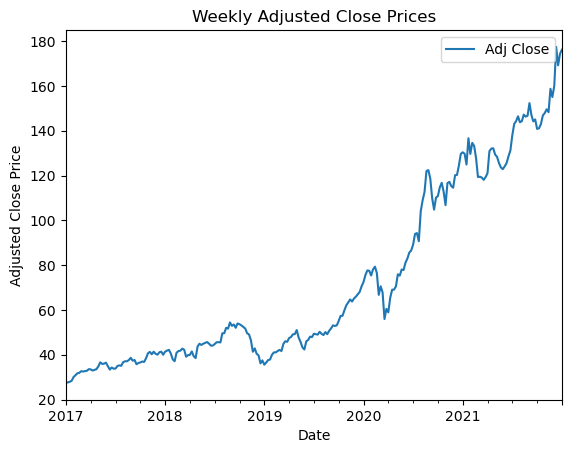

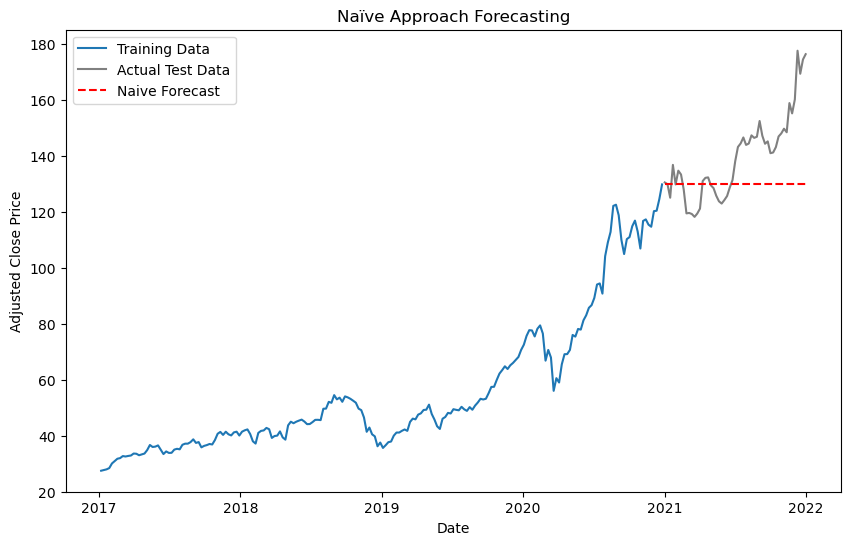

MAD: 13.16
MAPE: 8.84%
RMSE: 17.60


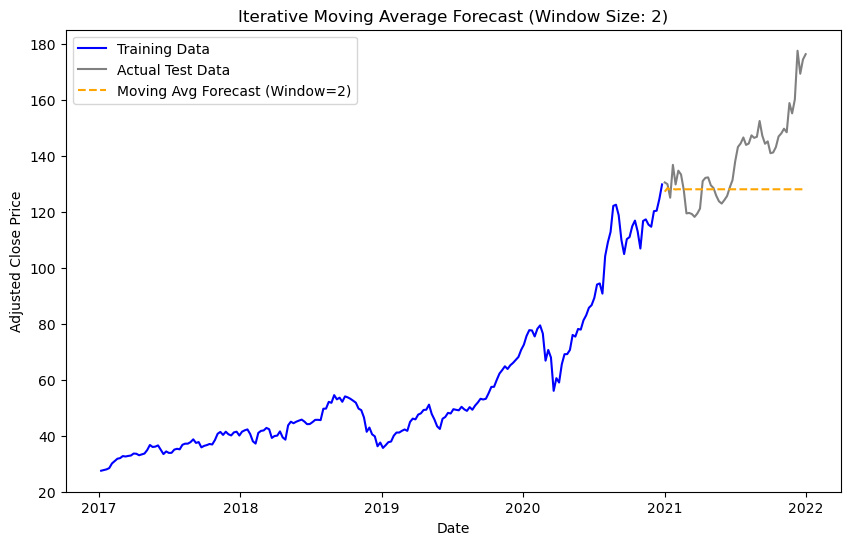

Window Size: 2
MAD: 13.94, MAPE: 9.33%, RMSE: 18.59



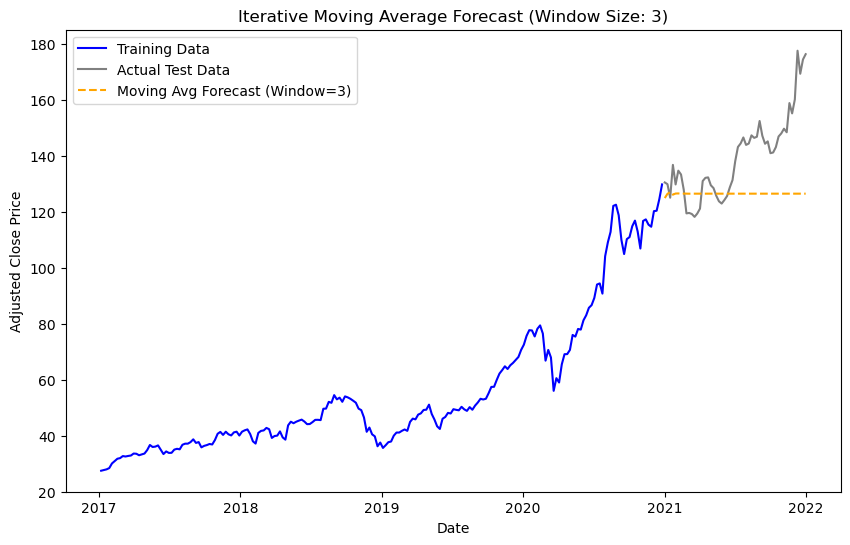

Window Size: 3
MAD: 14.84, MAPE: 9.91%, RMSE: 19.58



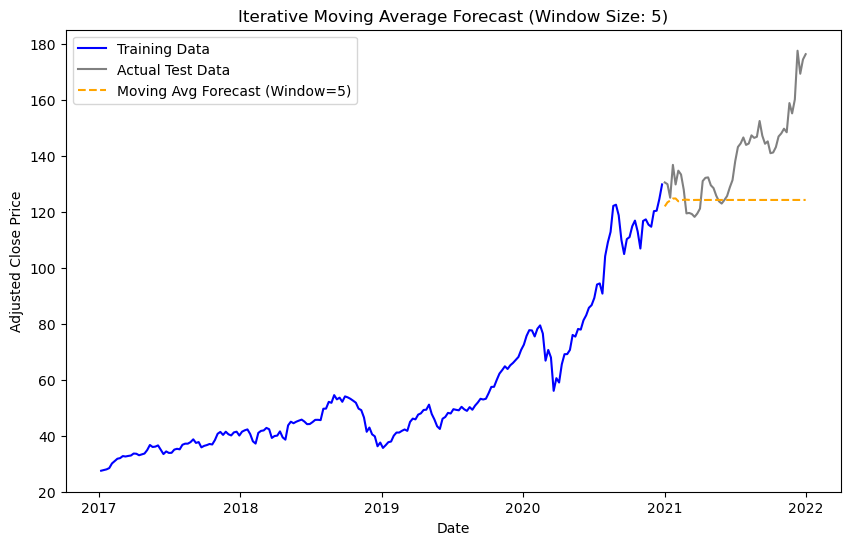

Window Size: 5
MAD: 16.22, MAPE: 10.83%, RMSE: 21.13



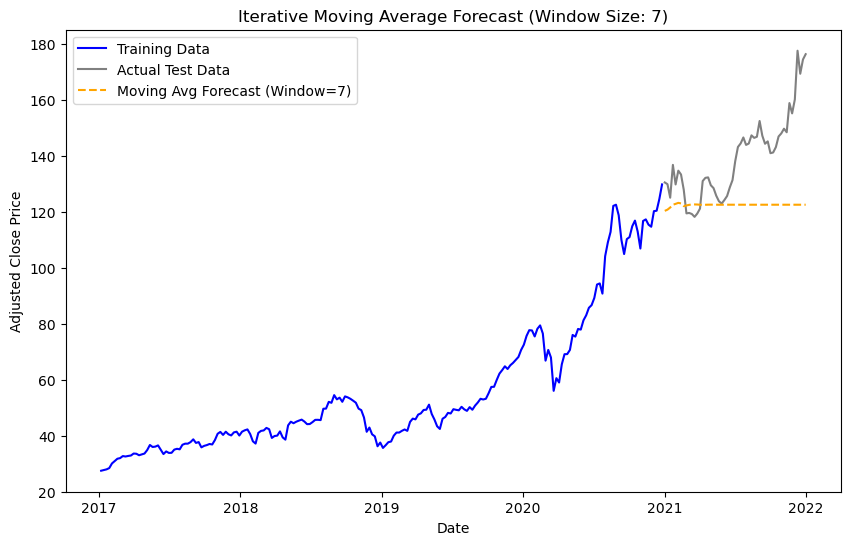

Window Size: 7
MAD: 17.48, MAPE: 11.70%, RMSE: 22.37



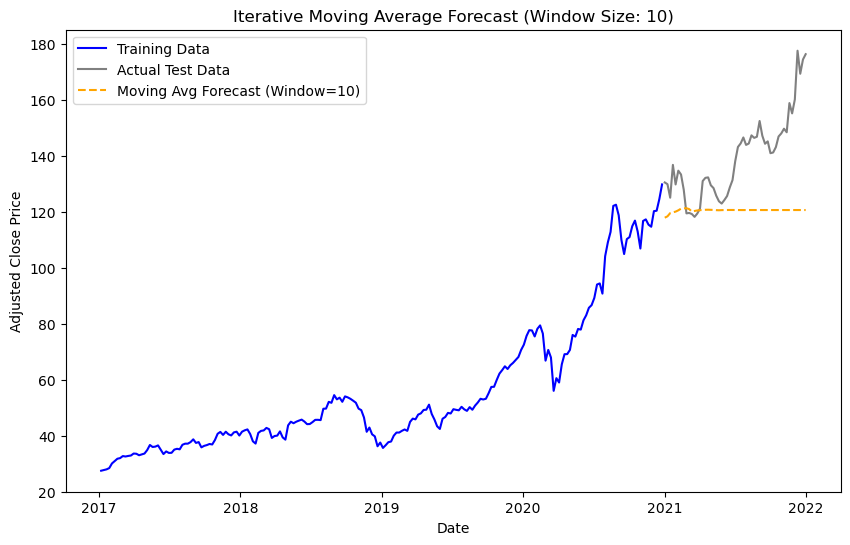

Window Size: 10
MAD: 19.01, MAPE: 12.77%, RMSE: 23.86



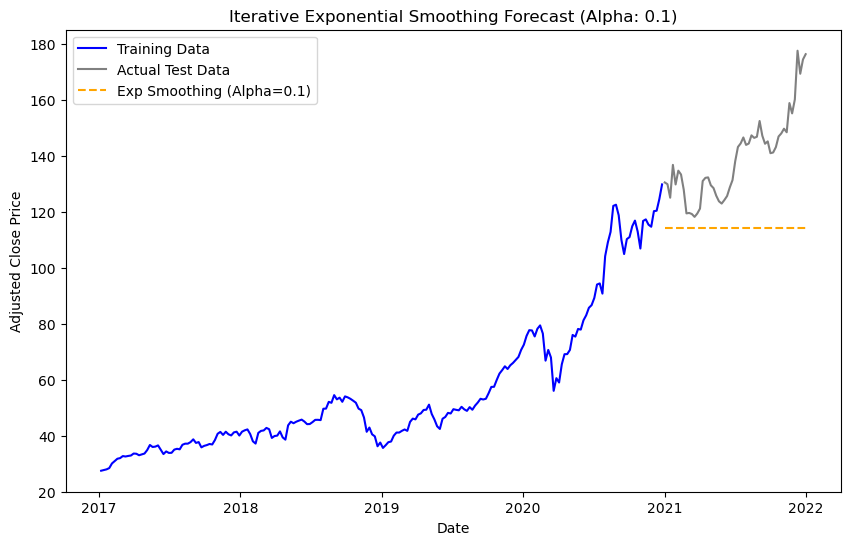

Alpha: 0.1
MAD: 25.07, MAPE: 17.13%, RMSE: 29.13



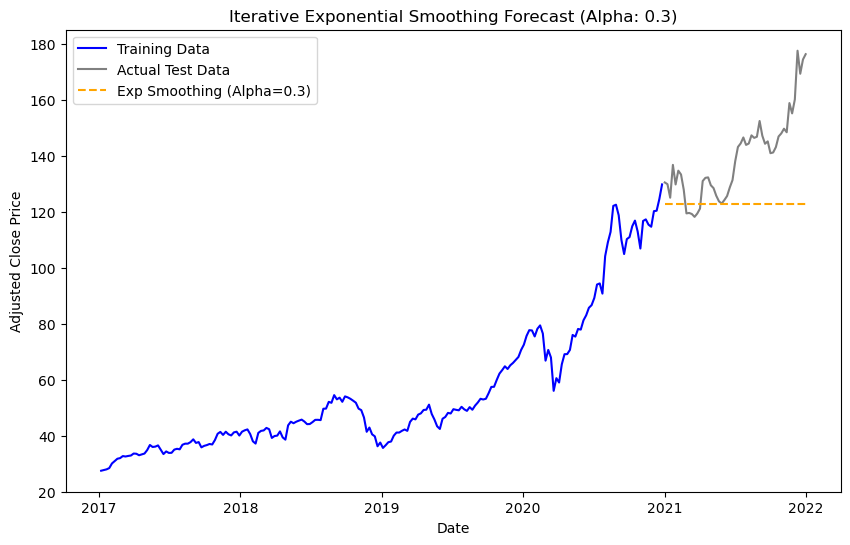

Alpha: 0.3
MAD: 17.29, MAPE: 11.56%, RMSE: 22.24



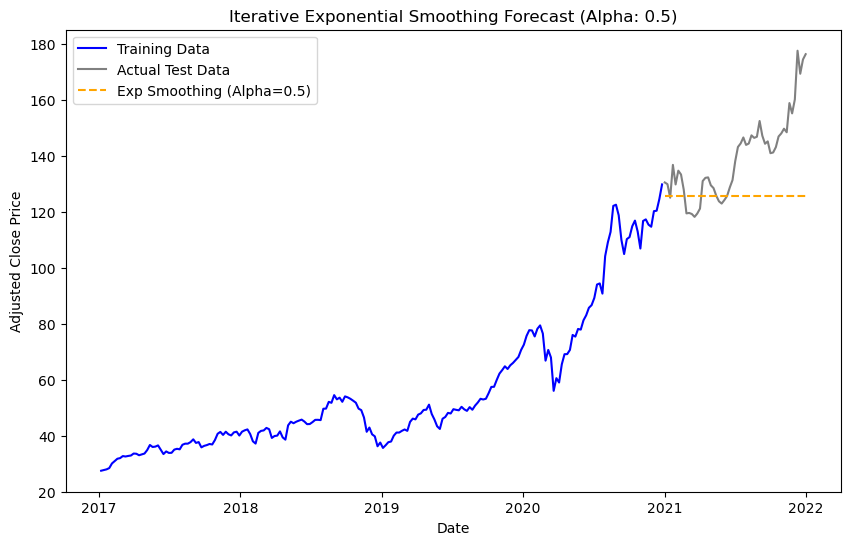

Alpha: 0.5
MAD: 15.17, MAPE: 10.12%, RMSE: 20.03



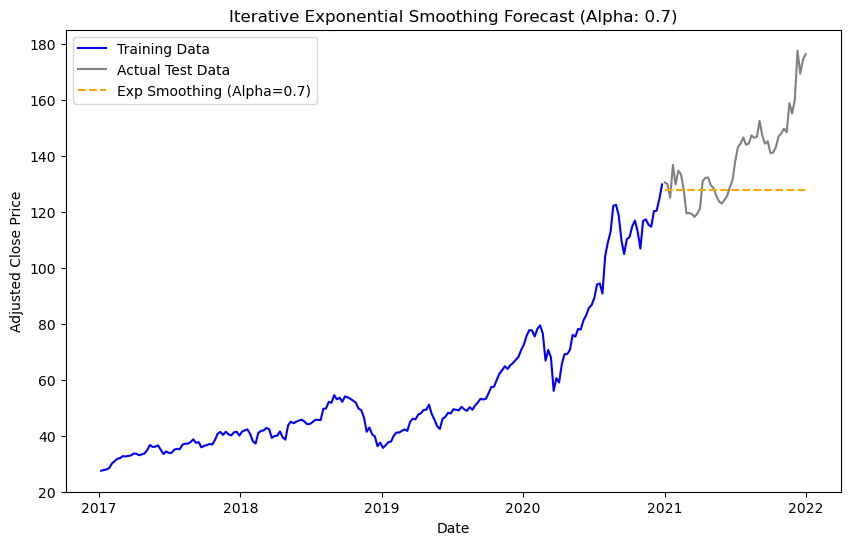

Alpha: 0.7
MAD: 14.07, MAPE: 9.41%, RMSE: 18.74



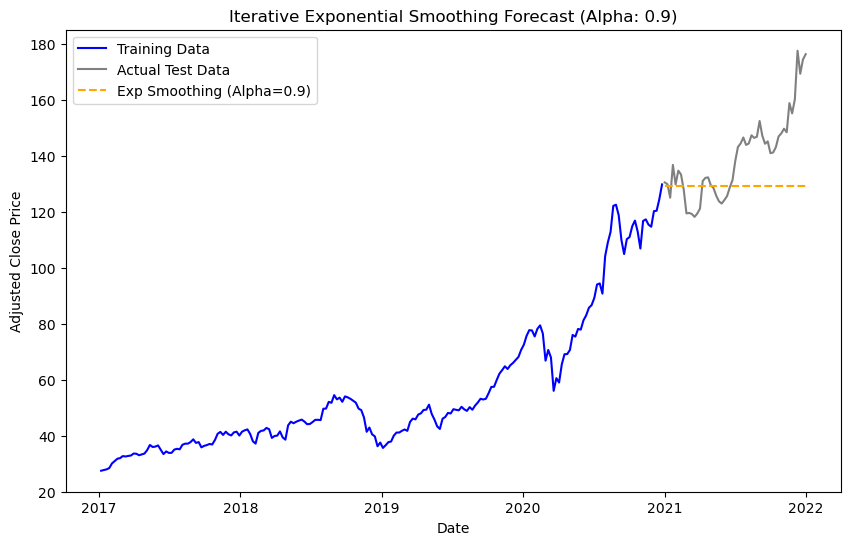

Alpha: 0.9
MAD: 13.39, MAPE: 8.98%, RMSE: 17.91



In [1]:
# Project Papadias

# A. Choose a data set of a quantity whose weekly values (e.g. closing price of a stock index every Monday) over 5 years are available. Go over this data set and make sure to clean it up of any inconsistencies, outliers, missing data, etc.

## Importing Libraries

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

## Getting the stock price data for APPLE

# Ticker symbol for company that we want to find (e.g., 'AAPL' for Apple Inc.)
ticker_symbol = 'AAPL'

# Time Period Interval
start_time = '2017-01-01'
end_time = '2021-12-31'

stock_data = yf.download(ticker_symbol, start=start_time, end=end_time)

csv_file_path = 'stock_data.csv'
stock_data.to_csv(csv_file_path)
print(f'Stock data has been saved to {csv_file_path}')

### Separating into weekly & Preprocessing/Cleaning

file_path = 'stock_data.csv'
stock_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)

weekly_data = stock_data.resample('W-FRI').agg({'Adj Close': 'last'})

# Check for missing values
cleaned_weekly_data = weekly_data.dropna()

# Drop duplicates
cleaned_weekly_data = weekly_data.drop_duplicates()

# Z-score for outlier detection
z_scores = np.abs(stats.zscore(cleaned_weekly_data['Adj Close']))
outlier_threshold = 3
outlier_indices = np.where(z_scores > outlier_threshold)
outliers = cleaned_weekly_data.iloc[outlier_indices]

print(f'Outliers:{outliers}')
print('\n')
print(cleaned_weekly_data.head())

#Saving to csv
csv_file_path = 'stock_data.csv'
cleaned_weekly_data.to_csv(csv_file_path)

cleaned_weekly_data

# Plotting the cleaned weekly data
cleaned_weekly_data.plot(title='Weekly Adjusted Close Prices')
plt.ylabel('Adjusted Close Price')
plt.show()

# B. Using the data for the first 4 years of your chosen (and cleaned up) data set, try to forecast the data of year 5. For this:

## a. Use three different forecasting techniques to perform the forecasting of level (without trend or seasonality adjustments). If a technique is parametric, try to choose the optimal value for this parameter.

## b. Compare these three techniques in two different ways.

### Naive Approach

file_path = 'stock_data.csv'
stock_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
cleaned_weekly_data = stock_data.resample('W-FRI').agg({'Adj Close': 'last'}).dropna()

train = cleaned_weekly_data[cleaned_weekly_data.index.year < 2021]
test = cleaned_weekly_data[cleaned_weekly_data.index.year == 2021]

naive_forecast = pd.DataFrame(index=test.index,columns=['Adj Close'])
naive_forecast['Adj Close'] = np.asarray(train['Adj Close'])[-1]

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Training Data')
plt.plot(test.index, test['Adj Close'], color='gray', label='Actual Test Data')
plt.plot(naive_forecast.index, naive_forecast['Adj Close'], color='red', linestyle='--', label='Naive Forecast')
plt.title('Naïve Approach Forecasting')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

naive_forecast = np.asarray(train['Adj Close'])[-1]
forecasted_values = np.full(len(test), naive_forecast)
mad = np.mean(np.abs(test['Adj Close'] - forecasted_values))
mape = np.mean(np.abs((test['Adj Close'] - forecasted_values) / test['Adj Close'])) * 100
rmse = np.sqrt(np.mean((test['Adj Close'] - forecasted_values) ** 2))

# Print MAD, MAPE, and RMSE
print(f'MAD: {mad:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')

### Moving Average

def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(predictions, targets))

# List of window sizes to try
window_sizes = [2, 3, 5, 7, 10]

for window_size in window_sizes:
    forecasted_values = []
    current_values = train['Adj Close'].tolist()

    # Iteratively forecast each point in the test set
    for i in range(len(test)):
        # Calculate the moving average with the most recent values
        if len(current_values) >= window_size:
            moving_avg = np.mean(current_values[-window_size:])
        else:
            moving_avg = np.mean(current_values)

        # Append the forecasted value and update the list for next iteration
        forecasted_values.append(moving_avg)
        current_values.append(moving_avg)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['Adj Close'], label='Training Data', color='blue')
    plt.plot(test.index, test['Adj Close'], label='Actual Test Data', color='gray')
    plt.plot(test.index, forecasted_values, linestyle='--', label=f'Moving Avg Forecast (Window={window_size})', color='orange')
    plt.title(f'Iterative Moving Average Forecast (Window Size: {window_size})')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.show()

    # Calculate error metrics
    mad = mean_absolute_error(test['Adj Close'], forecasted_values)
    mape = np.mean(np.abs((test['Adj Close'] - forecasted_values) / test['Adj Close'])) * 100
    calculated_rmse = rmse(test['Adj Close'], forecasted_values)

    print(f'Window Size: {window_size}')
    print(f'MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {calculated_rmse:.2f}\n')








### Exponential Smoothing

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

alphas = [0.1, 0.3, 0.5, 0.7, 0.9]  # Different alphas to try

for alpha in alphas:
    forecasted_values = []
    current_values = train['Adj Close'].tolist()

    # Iteratively apply exponential smoothing for each point in the test set
    for i in range(len(test)):
        if i == 0:
            model = SimpleExpSmoothing(current_values).fit(smoothing_level=alpha, optimized=False)
            next_forecast = model.forecast(1)[0]
        else:
            model = SimpleExpSmoothing(current_values + forecasted_values).fit(smoothing_level=alpha, optimized=False)
            next_forecast = model.forecast(1)[0]

        forecasted_values.append(next_forecast)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['Adj Close'], label='Training Data', color='blue')
    plt.plot(test.index, test['Adj Close'], label='Actual Test Data', color='gray')
    plt.plot(test.index, forecasted_values, linestyle='--', label=f'Exp Smoothing (Alpha={alpha})', color='orange')
    plt.title(f'Iterative Exponential Smoothing Forecast (Alpha: {alpha})')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.show()

    # Calculate error metrics
    mad = mean_absolute_error(test['Adj Close'], forecasted_values)
    mape = np.mean(np.abs((test['Adj Close'] - forecasted_values) / test['Adj Close'])) * 100
    calculated_rmse = rmse(test['Adj Close'], forecasted_values)

    print(f'Alpha: {alpha}')
    print(f'MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {calculated_rmse:.2f}\n')


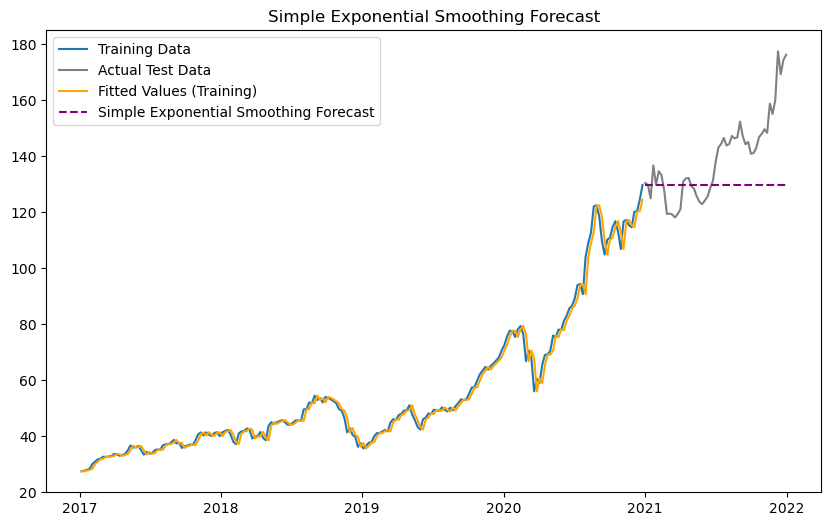

Estimated alpha (smoothing level): 0.9999999850988388
MAD: 13.16, MAPE: 8.84%, RMSE: 17.91



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(train)
result = model.fit()

forecast = result.forecast(len(test))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Training Data')
plt.plot(test.index, test['Adj Close'], color='gray', label='Actual Test Data')
plt.plot(result.fittedvalues, label='Fitted Values (Training)', color='orange')
plt.plot(forecast.index, forecast, label='Simple Exponential Smoothing Forecast', linestyle='--', color='purple')
plt.legend()
plt.title('Simple Exponential Smoothing Forecast')
plt.show()

alpha = result.params['smoothing_level']

print(f"Estimated alpha (smoothing level): {alpha}")

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mape = np.mean(np.abs((test['Adj Close'] - forecast) / test['Adj Close'])) * 100
rmse = np.sqrt(np.mean((test['Adj Close'] - forecast) ** 2))

print(f'MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {calculated_rmse:.2f}\n')

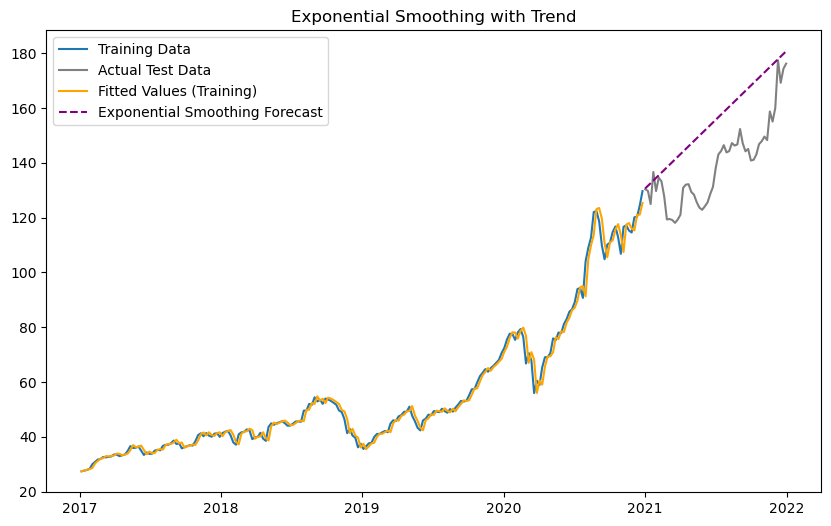

Estimated alpha (smoothing level): 0.9999999843119314
Estimated beta (smoothing trend): 0.01858372204444152
Estimated gamma (smoothing seasonal): nan
MAD: 16.64, MAPE: 12.26%, RMSE: 17.91



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend='add')
result = model.fit()

forecast = result.forecast(len(test))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Training Data')
plt.plot(test.index, test['Adj Close'], color='gray', label='Actual Test Data')
plt.plot(result.fittedvalues, label='Fitted Values (Training)', color='orange')
plt.plot(forecast.index, forecast, label='Exponential Smoothing Forecast', linestyle='--', color='purple')
plt.legend()
plt.title('Exponential Smoothing with Trend')
plt.show()

alpha = result.params['smoothing_level']
beta = result.params['smoothing_trend']
gamma = result.params['smoothing_seasonal']

print(f"Estimated alpha (smoothing level): {alpha}")
print(f"Estimated beta (smoothing trend): {beta}")
print(f"Estimated gamma (smoothing seasonal): {gamma}")

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mape = np.mean(np.abs((test['Adj Close'] - forecast) / test['Adj Close'])) * 100
rmse = np.sqrt(np.mean((test['Adj Close'] - forecast) ** 2))

print(f'MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {calculated_rmse:.2f}\n')

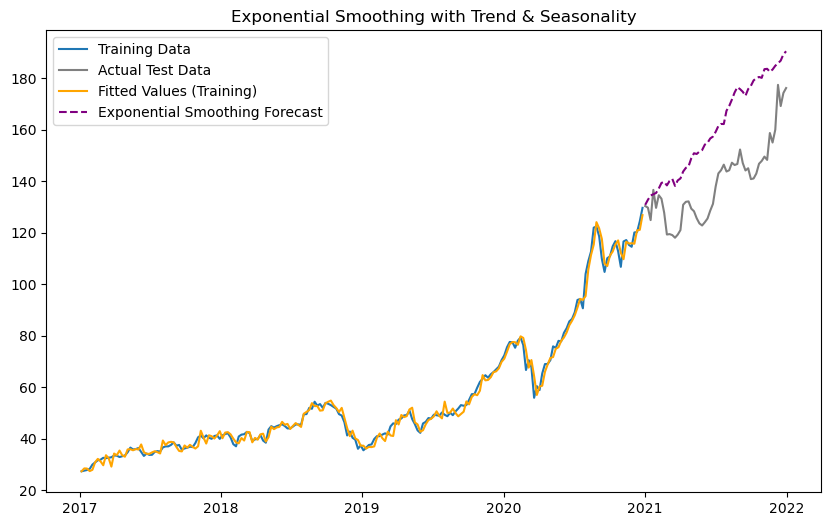

Estimated alpha (smoothing level): 0.9999999849856827
Estimated beta (smoothing trend): 0.026801198177373725
Estimated gamma (smoothing seasonal): 2.0476130481095956e-12
MAD: 21.42, MAPE: 15.48%, RMSE: 17.91



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend='add', seasonal='add')
result = model.fit()

forecast = result.forecast(len(test))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Training Data')
plt.plot(test.index, test['Adj Close'], color='gray', label='Actual Test Data')
plt.plot(result.fittedvalues, label='Fitted Values (Training)', color='orange')
plt.plot(forecast.index, forecast, label='Exponential Smoothing Forecast', linestyle='--', color='purple')
plt.legend()
plt.title('Exponential Smoothing with Trend & Seasonality')
plt.show()

alpha = result.params['smoothing_level']
beta = result.params['smoothing_trend']
gamma = result.params['smoothing_seasonal']

print(f"Estimated alpha (smoothing level): {alpha}")
print(f"Estimated beta (smoothing trend): {beta}")
print(f"Estimated gamma (smoothing seasonal): {gamma}")

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mape = np.mean(np.abs((test['Adj Close'] - forecast) / test['Adj Close'])) * 100
rmse = np.sqrt(np.mean((test['Adj Close'] - forecast) ** 2))

print(f'MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {calculated_rmse:.2f}\n')